# Testing KERAS classification with MLP

In [1]:
from fastespy.mlkeras.evaluation import SplitData, plot_metric, plot_sig_vs_thr, get_sig_bkg_rate_eff, get_tp_fp_fn
from fastespy.mlkeras import models
from fastespy.ml import MLHyperParTuning
from fastespy.readpydata import convert_data_to_ML_format
from fastespy import feldman_cousins as fc
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow import keras
import matplotlib.pyplot as plt
import sys
import glob
import os
import tempfile
import logging
import numpy as np
from pathlib import PosixPath
from fastespy.analysis import init_logging
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
sys.path.append("/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

## Read data 

In [4]:
path = "/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/"
in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

if not len(files):
    path = "/Users/manuelmeyer/Python/TESdata/data-05122021/"
    in_dir = PosixPath(path)
    files = glob.glob(os.path.join(path, '*.npy'))
    print(len(files))

8


In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3247362142.py:   3 --- INFO: Using files:
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-4-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-2-triggertimefixed.pickle.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-36hrs-1-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/newsettings-0.3RN-1.5GHzGBWP-50MHz-20mV-light-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-5-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Download

Do a log transform

In [6]:
X_log, y_log = MLHyperParTuning.transform_data_log(X.copy(), y.copy(), feature_names)

Discarded 89 triggers in log transform


/Users/manuelmeyer/Python/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


Get a split of the data (will be repeated later on):

In [7]:
sd = SplitData(X_log, y_log, n_splits=5, stratify=True, random_state=42)

In [8]:
i_split = 0
#X_train, X_test, y_train, y_test = sd.get_split(i_split)
X_train, X_test, y_train, y_test = sd.get_split_with_test_set(m=i_split, n=0)

Normalize the data

In [9]:
# normalize the input data
normalizer = Normalization(axis=-1)

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_test = normalizer(X_test)

### Define the model

In [10]:
initial_bias, initial_loss = models.initial_output_bias(y_train)
print(initial_bias, initial_loss)

[-1.16817499] [0.54781338]


In [24]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

In [25]:
model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4
                             )

In [26]:
EPOCHS = 100
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

# early stopping if loss of validation set does not improve
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


Initial predictions

In [27]:
model.predict(X_train[10:]), y_train.sum() / y_train.size

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x2d16e6820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(array([[0.23631197],
        [0.23299159],
        [0.2357638 ],
        ...,
        [0.23003845],
        [0.23708966],
        [0.2394351 ]], dtype=float32),
 0.23718502237224273)

In [28]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2d1c6e9d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
results['loss'], initial_loss

(0.5575078129768372, array([0.54781338]))

Save the inital weights

In [30]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights_{n_layers}_{n_nodes}')
model.save_weights(initial_weights)

### Train the full model

In [31]:
use_weights = False # setting to true will let notebook crash on my new mac.... works on old one

# weighting following
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# original: increasing weight for class 1:
# false negatives go down, false positives go up
# significance goes down
weight_for_0 = 1 / (y.size - y.sum()) * (y.size / 2.)
weight_for_1 = 1 / y.sum() * (y.size / 2.)

# inverting weights: fp down, fn up, significance up!
# power 2 better than power 1, power 3 worse
power = 2.
weight_for_0 = 1. / (1 / (y.size - y.sum()) * (y.size / 2.))**power
weight_for_1 = 1. / (1 / y.sum() * (y.size / 2.))**power

if use_weights:
    class_weight = {0: weight_for_0, 1: weight_for_1}
else:
    class_weight = None
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))



Weight for class 0: 2.33
Weight for class 1: 0.22


In [32]:
model.summary()
model.load_weights(initial_weights)

Model: "mlp_binary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense4 (Dense)               (None, 100)               1

In [33]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0,
    class_weight=class_weight
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2d16e6430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:47:50.089724: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:47:50.089831: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:47:50.089843: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:47

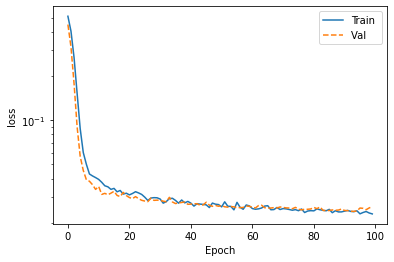

In [34]:
plot_metric(baseline_history)
plt.legend()

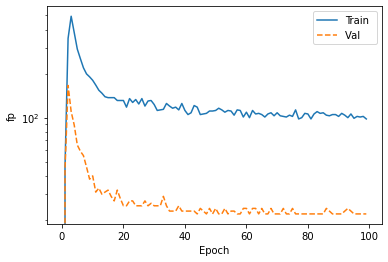

In [35]:
plot_metric(baseline_history, metric='fp')
plt.legend()

Max significance: 3.28 for threshold 0.9629 background rate 1.85e-05 and analysis efficiency 0.87


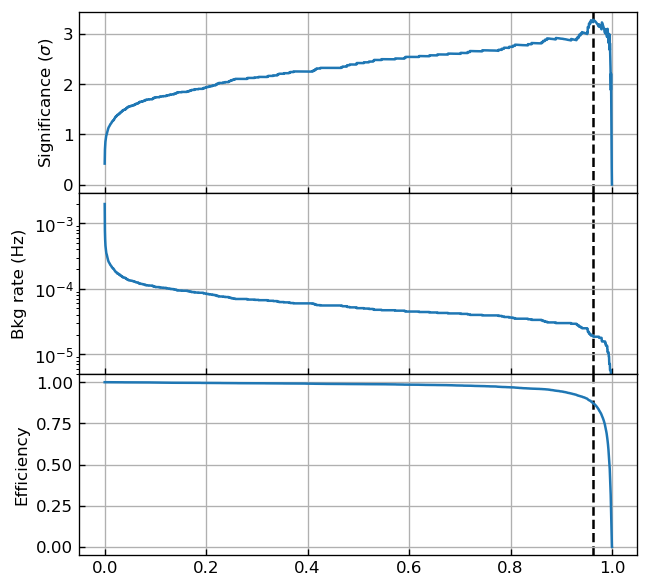

In [36]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_train,
                                                             y_train,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_test.size)
plt.subplots_adjust(hspace=0.)

Significance for test set with the threshold obtained from training set:

In [37]:
imax = np.argmax(significance)

In [42]:
y_pred = model.predict(normalizer(sd.X_test))

In [43]:
class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=threshold[imax])

sig, bkg_rate, eff = get_sig_bkg_rate_eff(sd.y_test,
                                          y_pred,
                                          N_tot=y_train.size + y_test.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=threshold[imax])

In [44]:
print(sig, bkg_rate, eff)

4.3522804841117715 8.551446521283776e-06 0.8793012175754368


Plot false positives

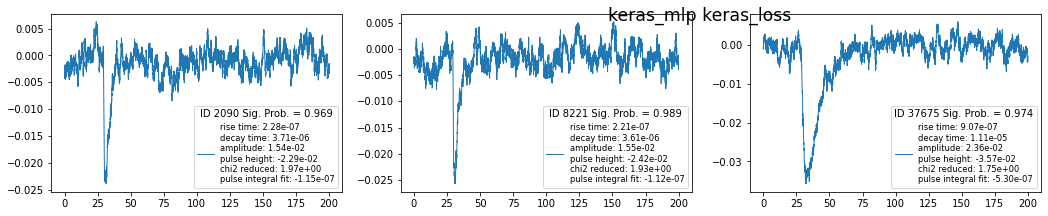

In [46]:
d = {}
d['y_test'] = sd.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = sd.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred, y_pred])}
d['classifier'] = "keras_mlp"

if fp.sum() < 50:
    ax = MLHyperParTuning.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=True, save_plot=False
    )

### Learning curve

### Repeat analysis over different folds

In [47]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x3a0de6f70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x81aa05dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:57:11.726640: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:11.726764: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:11.726777: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x3a7f7e8b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 3.11 for threshold 0.9795 background rate 1.87e-05 and analysis efficiency 0.82
1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x62e10b940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x730b35940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:57:24.949657: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:24.949793: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:24.949810: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x81a7fde50> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 3.03 for threshold 0.9879 background rate 1.87e-05 and analysis efficiency 0.80
2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x732909a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x81a7fd040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:57:38.875389: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:38.875991: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:38.876004: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x3a7f60430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 2.81 for threshold 0.9792 background rate 2.49e-05 and analysis efficiency 0.84
3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x3a0c8ca60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x73474f280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:57:52.556474: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:52.556880: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57:52.557017: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:57

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x62e004f70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 2.93 for threshold 0.9869 background rate 2.05e-05 and analysis efficiency 0.80
4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x818d2fc10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x3a22a0700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-24 15:58:06.065978: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:58:06.067357: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:58:06.067372: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-24 15:58

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x3a2285dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 2.93 for threshold 0.9900 background rate 2.23e-05 and analysis efficiency 0.83


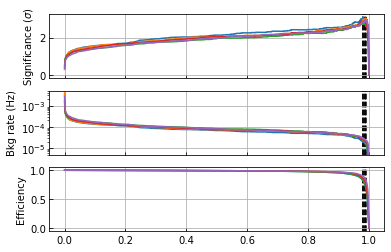

In [53]:
sig, br, ef = np.zeros(5), np.zeros(5), np.zeros(5)

for i in range(5):
    print(i)
    X_train, X_test, y_train, y_test = sd.get_split_with_test_set(m=i, n=0)
    
    # normalize the input data
    normalizer = Normalization(axis=-1)

    # adapt to training data
    normalizer.adapt(X_train)

    # normalize training data
    X_train = normalizer(X_train)
    X_test = normalizer(X_test)
    
    # calculate initial bias
    initial_bias, initial_loss = models.initial_output_bias(y_train)
    
    # the model
    model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4
                             )
    
    # fit the model
    history = model.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_test, y_test), 
                        verbose=0,
                        class_weight=class_weight
                        )
    
    # compute best threshold 
    ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                                 X_train,
                                                                 y_train,
                                                                 t_obs_hours=t_tot_hrs,
                                                                 N_tot=y_train.size + y_test.size + sd.y_test.size)
    
    imax = np.argmax(significance)
    y_pred = model.predict(normalizer(sd.X_test))
    class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=threshold[imax])

    sig[i], br[i], ef[i] = get_sig_bkg_rate_eff(sd.y_test,
                                                y_pred,
                                                N_tot=y_train.size + y_test.size + sd.y_test.size,
                                                t_obs=t_tot_hrs * 3600.,
                                                thr=threshold[imax])
    
    del model

In [66]:
mean = np.vstack([sig, br, ef]).mean(axis=1)
std = np.sqrt(np.vstack([sig, br, ef]).var(axis=1))

print(mean)
print(std)

[4.34327044e+00 7.41125365e-06 8.23398624e-01]
[3.14675966e-01 1.39644537e-06 1.50426092e-02]
